### Define simulator

In [1]:
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import FakeManilaV2

# Build noise model from backend properties
backend = FakeManilaV2()
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map
print(coupling_map)

simulator_noisy = AerSimulator(method="density_matrix",
                               noise_model=noise_model)

[[0, 1], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3]]


### Prepare QREM framework

In [2]:
from qiskit.circuit import QuantumRegister
# prepare calibration circuit (same as qiskit tutorial)

num_qubits = 4
qr = QuantumRegister(num_qubits)
mit_pattern = [[0], [1], [2], [3]] ### This indicates which sets of qubits to mitigate taking the correlated error into account.
### mit_pattern = [[0], [1], [2, 3]] ### correlated error is currently not supported (bug found).

# create quantum circuits for calibrating readout errors
from libs_qrem import tensored_meas_cal
qcs_qrem, _ = tensored_meas_cal(mit_pattern=mit_pattern, qr=qr, circlabel='mcal')

# run calibration circuit (same as qiskit tutorial) using the simulated fake backend
results_qrem = simulator_noisy.run(circuits=qcs_qrem,
                                   shots=5000).result()

from libs_qrem import TensoredMeasFitter
meas_fitter = TensoredMeasFitter(results_qrem, mit_pattern=mit_pattern)

# Create mitigator instance (corresponds to meas_fitter.filter in the tutorial code.)
# this is very similar to the usage of qiskit.ignis.mitigation modules 
# meas_filter = meas_fitter.filter
from libs_qrem import LeastNormFilter
meas_filter = LeastNormFilter(num_qubits, meas_fitter.cal_matrices)

### Demonstrate with GHZ state

In [3]:
from qiskit.circuit import QuantumCircuit

qc_ghz = QuantumCircuit(num_qubits, num_qubits)
qc_ghz.h(0)
for ith_qubit in range(num_qubits - 1):
    qc_ghz.cx(ith_qubit, ith_qubit + 1)
for ith_qubit in range(num_qubits):
    qc_ghz.measure(ith_qubit, ith_qubit)

result_ghz = simulator_noisy.run(circuits=qc_ghz,
                                 shots=5000).result()

result_ghz_mitigated = meas_filter.apply(result_ghz)

hist_ghz = result_ghz.get_counts()
hist_ghz_mitigated = result_ghz_mitigated.get_counts()

### Visualisation of histograms

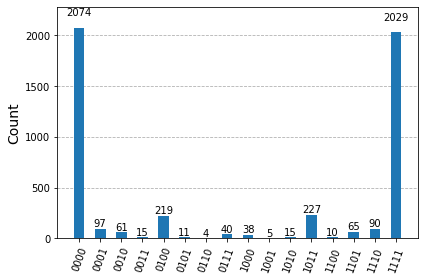

In [4]:
from qiskit.visualization import plot_histogram
plot_histogram(hist_ghz)

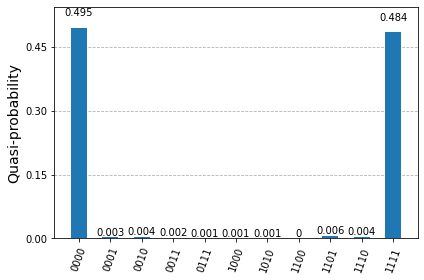

In [5]:
plot_histogram(hist_ghz_mitigated)